Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [1]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2

import sys
import os
sys.path.append(os.getcwd() + '/..')
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer

In [2]:
batch_size = 128
learning_rate = 2e-3
num_epochs = 300

latent_dim = 16
#terms = 10
kernels = 2

prefix = f"fuzzy_classifier"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [3]:
def norm_and_transform(x):
    nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(nimg, -1, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, -1, 1)
    return nimg

train_transform = transforms.Compose([
    transforms.ToTensor(), 
    #transforms.RandomCrop(size=25),
    #transforms.Resize(size=(28, 28)),
    #transforms.Lambda(norm_and_transform)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Lambda(norm_and_transform)
])


In [4]:
def get_target_and_mask(target_label):
    t = F.one_hot(torch.LongTensor([target_label]), 10)
    return t.squeeze().to(torch.float)

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = train_transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

len(train_data)

60000

загружаем тестовую выборку

In [5]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=test_transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [6]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

torch.Size([128, 10])


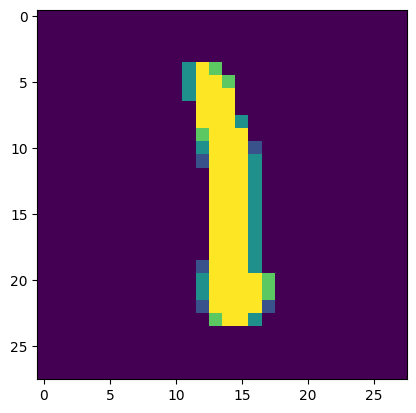

In [7]:
for data, t in iter(train_loader):
    plt.imshow(data[0].squeeze().cpu())
    print(t.shape)
    break

## Модель

In [20]:
class FuzzyClassifier(nn.Module):
    """
    
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, terms):
        super(FuzzyClassifier, self).__init__()
                
        self.input = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size=7, padding=6, stride=1),
            nn.BatchNorm2d(kernels, track_running_stats=False),
            nn.SiLU(),  
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(kernels, 2*kernels, kernel_size=2, stride=1, padding = 0),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(2*kernels, 2*kernels, kernel_size=2, stride=1, padding =0),
            nn.BatchNorm2d(2*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.MaxPool2d(2, stride = 2),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(4*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(8*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(8*kernels, 8*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(8*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_5 = nn.Sequential(
            nn.Conv2d(8*kernels, 16*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(16*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(16*kernels, 16*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(16*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_6 = nn.Sequential(
            nn.Conv2d(16*kernels, 32*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(32*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(32*kernels, 32*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(32*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_7 = nn.Sequential(
            nn.Conv2d(32*kernels, 64*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(64*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(64*kernels, 64*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(64*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_8 = nn.Sequential(
            nn.Conv2d(64*kernels, 128*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(128*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(128*kernels, 128*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(128*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.block_9 = nn.Sequential(
            nn.Conv2d(128*kernels, 256*kernels, kernel_size = 2, stride=1, padding = 0),
            nn.BatchNorm2d(256*kernels, track_running_stats=False),
            nn.SiLU(),  
            nn.Conv2d(256*kernels, 256*kernels, kernel_size = 3, stride=1, padding = 0),
            nn.BatchNorm2d(256*kernels, track_running_stats=False),
            nn.SiLU(),  
            #nn.MaxPool2d(2, stride = 2),
        )

        self.prefuzzy = nn.Sequential(
            #nn.AvgPool2d(kernel_size = 3, stride = 1),
            nn.Flatten(),
            nn.Linear(256*kernels, latent_dim),
        )

        #terms_list = []
        #for d in range(10):
        #    terms_list.append(nn.Sequential(
        #        FuzzyBellLayer.from_dimensions(latent_dim, terms, trainable=True)))

        self.fuzzy = nn.Sequential(
            FuzzyLayer.from_dimensions(latent_dim, 10, trainable=True)) #nn.ParameterList(terms_list)

        # self.out = nn.Sequential(
        #     nn.Linear(10*terms, 10)
        # )
        
        self.downscale_1 = nn.Sequential(nn.Conv2d(  kernels, 2*kernels, kernel_size=19))
        self.downscale_2 = nn.Sequential(nn.Conv2d(2*kernels, 4*kernels, kernel_size=3))
        self.downscale_3 = nn.Sequential(nn.Conv2d(4*kernels, 8*kernels, kernel_size=3))
        self.downscale_4 = nn.Sequential(nn.Conv2d(8*kernels, 16*kernels, kernel_size=3))
        self.downscale_5 = nn.Sequential(nn.Conv2d(16*kernels, 32*kernels, kernel_size=3))
        self.downscale_6 = nn.Sequential(nn.Conv2d(32*kernels, 64*kernels, kernel_size=3))
        self.downscale_7 = nn.Sequential(nn.Conv2d(64*kernels, 128*kernels, kernel_size=3))
        self.downscale_8 = nn.Sequential(nn.Conv2d(128*kernels, 256*kernels, kernel_size=4))
        self.after_sum = nn.SiLU()
        

         
    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.input(x)
        #print(x.shape)
        res_1 = self.downscale_1(x)
        #print(res_1.shape)
        

        x = self.block_2(x)
        #print(x.shape)
        x = self.after_sum(x+res_1)
        res_2 = self.downscale_2(x)
        #print(res_2.shape)
        
        x = self.block_3(x)
        #print(x.shape)
        x = self.after_sum(x+res_2)
        res_3 = self.downscale_3(x)
        #print(res_3.shape)
        
        x = self.block_4(x)
        #print(x.shape)
        x = self.after_sum(x+res_3)
        res_4 = self.downscale_4(x)
        #print(res_4.shape)

        x = self.block_5(x)
        #print(x.shape)
        x = self.after_sum(x + res_4)
        res_5 = self.downscale_5(x)
        #print(res_5.shape)

        x = self.block_6(x)
        #print(x.shape)
        x = self.after_sum(x + res_5)
        res_6 = self.downscale_6(x)
        #print(res_6.shape)

        x = self.block_7(x)
        #print(x.shape)
        x = self.after_sum(x + res_6)
        res_7 = self.downscale_7(x)
        #print(res_7.shape)

        x = self.block_8(x)
        #print(x.shape)
        x = self.after_sum(x + res_7)
        res_8 = self.downscale_8(x)
        #print(res_8.shape)

        x = self.block_9(x)
        #print(x.shape)
        x = self.after_sum(x + res_8)

        x = self.prefuzzy(x)# 7
        #chunks = x.split(latent_dim, dim=-1)
        #acts = []

        #for d in range(10):
        #    acts.append(self.fuzzy[d](chunks[d]))

        #x = torch.stack(acts, 1).squeeze().flatten(1)
        
        #print(x.shape)
        x = self.fuzzy(x)

        return x

inp = torch.rand(5, 1, 28, 28)
m = FuzzyClassifier(latent_dim, 10)
mu = m.forward(inp)
mu

tensor([[0.0139, 0.0089, 0.0092, 0.0081, 0.0120, 0.0443, 0.0266, 0.0049, 0.0078,
         0.0066],
        [0.0173, 0.0059, 0.0109, 0.0097, 0.0162, 0.0323, 0.0293, 0.0063, 0.0068,
         0.0123],
        [0.0095, 0.0025, 0.0144, 0.0100, 0.0110, 0.0289, 0.0311, 0.0080, 0.0056,
         0.0104],
        [0.0177, 0.0085, 0.0106, 0.0075, 0.0152, 0.0432, 0.0286, 0.0060, 0.0082,
         0.0076],
        [0.0259, 0.0065, 0.0118, 0.0108, 0.0186, 0.0335, 0.0332, 0.0051, 0.0086,
         0.0075]], grad_fn=<TransposeBackward0>)

## Обучение

In [9]:
model = FuzzyClassifier(latent_dim=latent_dim, terms=10).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 5,917,972


FuzzyClassifier(
  (input): Sequential(
    (0): Conv2d(1, 2, kernel_size=(7, 7), stride=(1, 1), padding=(6, 6))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): SiLU()
  )
  (block_2): Sequential(
    (0): Conv2d(2, 4, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): SiLU()
    (3): Conv2d(4, 4, kernel_size=(2, 2), stride=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): SiLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Conv2d(4, 8, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): SiLU()
    (3): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5):

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.8)

In [11]:
criterion = nn.BCELoss(reduction='sum')
def compute_classification_loss(fz, target):
    return criterion(fz, target)

In [12]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [13]:
def compute_fshape_loss(fuzzy_layer):
    
    eigens = fuzzy_layer.get_transformation_matrix_eigenvals().real
    fz_volume = (0.1 - (eigens.min(-1).values/eigens.max(-1).values).clamp(max=0.1)).square()
    fz_volume = fz_volume.mean()

    return fz_volume
    

In [14]:
def train(model, dataloader, optimizer, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()  

        pred = model.forward(data)  

        loss = compute_classification_loss(pred, target)

        ev_loss = keep_eigenvals_positive_loss(model.fuzzy[0])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        #fzloss =  compute_fshape_loss(model.fuzzy[0])
        #fzloss.backward(retain_graph=True)
        
        # for fd in range(10):
        #     fzloss =  compute_fshape_loss(model.fuzzy[fd][0])
        #     fzloss.backward(retain_graph=True)
        #     ev_loss = keep_eigenvals_positive_loss(model.fuzzy[fd][0])
        #     if ev_loss.item() > 0:
        #         ev_loss.backward(retain_graph=True)
        
        loss.backward() 
        
        optimizer.step()  

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 
    loss_accuracy = 0
    loss_count = 0
    total_loss = []
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            target = target.to(device)
            data = data.to(device)
            pred = model.forward(data)  
            pred_lab = pred.max(-1).indices.squeeze().cpu()
            exp_lab = target.max(-1).indices.squeeze().cpu()

            loss_accuracy += (pred_lab == exp_lab).float().sum()
            loss_count += pred_lab.shape[0]

            total_loss.append(compute_classification_loss(pred, target).item())

    loss_accuracy /= loss_count
    print(f'[{cur_step}] Accuracy : {loss_accuracy:.4f} Loss {np.mean(total_loss):4f} ')
    
    if writer is not None:
        writer.add_scalar('FCL/Accuracy', loss_accuracy, global_step=cur_step)
        writer.add_scalar('FCL/Loss', np.mean(total_loss), global_step=cur_step)
    return loss_accuracy

In [16]:
prev_updates = 0

In [17]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, prev_updates, epoch, writer=writer)
    acc = test(model, test_loader, prev_updates, epoch, writer=writer)
    scheduler.step(acc)


[469] Accuracy : 0.9828 Loss 48.634751 
[938] Accuracy : 0.9882 Loss 29.288891 
[1407] Accuracy : 0.9866 Loss 30.906555 
[1876] Accuracy : 0.9900 Loss 25.748421 
[2345] Accuracy : 0.9901 Loss 23.237551 
[2814] Accuracy : 0.9910 Loss 24.446680 
[3283] Accuracy : 0.9912 Loss 19.265895 
[3752] Accuracy : 0.9894 Loss 24.202596 
[4221] Accuracy : 0.9909 Loss 22.167453 
[4690] Accuracy : 0.9905 Loss 19.322405 
[5159] Accuracy : 0.9908 Loss 21.763817 
[5628] Accuracy : 0.9921 Loss 18.941500 
[6097] Accuracy : 0.9933 Loss 13.757289 
[6566] Accuracy : 0.9922 Loss 14.191890 
[7035] Accuracy : 0.9905 Loss 17.693182 
[7504] Accuracy : 0.9907 Loss 19.947558 
[7973] Accuracy : 0.9914 Loss 14.342822 
[8442] Accuracy : 0.9917 Loss 14.560203 
[8911] Accuracy : 0.9916 Loss 13.866758 
[9380] Accuracy : 0.9905 Loss 16.040753 
[9849] Accuracy : 0.9919 Loss 16.716242 
[10318] Accuracy : 0.9896 Loss 15.554173 
[10787] Accuracy : 0.9929 Loss 13.755700 
[11256] Accuracy : 0.9936 Loss 12.783533 
[11725] Accurac

In [19]:
keep_eigenvals_positive_loss(model.fuzzy[0])

tensor(2.0072e-07, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты